References: https://www.kaggle.com/kernels/scriptcontent/23917647/download

In [1]:
folds = 3

debug = False
num_rounds = 1000

# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [3]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [4]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

CPU times: user 184 ms, sys: 383 ms, total: 567 ms
Wall time: 678 ms


In [5]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [6]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [7]:
plot_date_usage(train_df, meter=0, building_id=0)

In [8]:
plot_date_usage(train_df, meter=0, building_id=105)

In [9]:
plot_date_usage(train_df, meter=0, building_id=156)

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [10]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [11]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

## FIX Time Zone

In [12]:
zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

def set_localtime(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

In [13]:
set_localtime(weather_train_df)

## Add time feature

In [14]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

In [15]:
preprocess(train_df)

In [16]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_median = df_group.median().astype(np.float16)


train_df['building_median'] = train_df['building_id'].map(building_median)
del df_group

In [17]:
#building_mean.head()

## Fill Nan value in weather dataframe by interpolation

In [18]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [19]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0
1,0,0,1,7062,1,8763,52,3,0
2,0,0,1,2354,1,66,44,591,5
3,0,0,4,3642,6,37,158,153,4
4,0,0,0,4230,2,1317,73,105,0
5,0,0,2,6030,2,8755,8755,295,3
6,0,0,10,2992,10,0,175,779,39
7,0,0,0,8614,23,7883,8,0,0
8,0,0,3,3830,3,1,85,250,0


In [20]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [21]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

In [22]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0
1,0,2015-12-31 21:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [23]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [24]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [25]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1307.51 MB
Memory usage after optimization is: 625.34 MB
Decreased by 52.2%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 3.07 MB
Decreased by 37.8%


In [26]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [27]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed',]

In [28]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [29]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [30]:
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
oof_total = 0

## Train model by each meter type

### meter 0 : 0: electricity

target_meter 0 (11714696, 15)
cat_features [12, 13, 14]
train 7809797 valid 3904899
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.693295	valid_1's l2: 0.716831
[40]	training's l2: 0.422655	valid_1's l2: 0.491045
[60]	training's l2: 0.363707	valid_1's l2: 0.47068
Early stopping, best iteration is:
[54]	training's l2: 0.376601	valid_1's l2: 0.466698
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.37660123926373806)]), 'valid_1': OrderedDict([('l2', 0.46669800260138916)])})
train 7809797 valid 3904899
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.669657	valid_1's l2: 0.755028
[40]	training's l2: 0.406738	valid_1's l2: 0.50384
[60]	training's l2: 0.355888	valid_1's l2: 0.458328
[80]	training's l2: 0.334641	valid_1's l2: 0.439282
[100]	training's l2: 0.31601	valid_1's l2: 0.428528
[120]	training's l2: 0.302725	valid_1's l2: 0.423684
Early stopping, best iteration is:
[119]	training's l2: 0.30356	valid_1's l2: 0.423074
best_score defaultdict(<

15

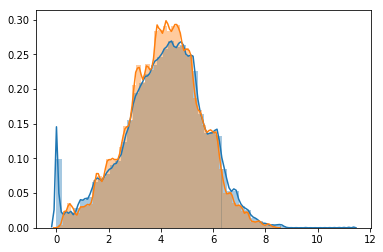

In [31]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof0 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof0 * len(y_train)

del X_train, y_train
gc.collect()

In [32]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

### 1:chilledwater

target_meter 1 (4182440, 15)
cat_features [12, 13, 14]
train 2788293 valid 1394147
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.39697	valid_1's l2: 2.91009
[40]	training's l2: 1.70609	valid_1's l2: 2.14658
[60]	training's l2: 1.50746	valid_1's l2: 2.01355
[80]	training's l2: 1.40446	valid_1's l2: 1.96885
[100]	training's l2: 1.34341	valid_1's l2: 1.94912
[120]	training's l2: 1.29914	valid_1's l2: 1.93541
[140]	training's l2: 1.26065	valid_1's l2: 1.92819
[160]	training's l2: 1.23319	valid_1's l2: 1.9239
[180]	training's l2: 1.21071	valid_1's l2: 1.91949
[200]	training's l2: 1.19208	valid_1's l2: 1.9151
[220]	training's l2: 1.17473	valid_1's l2: 1.91418
[240]	training's l2: 1.16216	valid_1's l2: 1.90899
[260]	training's l2: 1.15166	valid_1's l2: 1.90702
[280]	training's l2: 1.1406	valid_1's l2: 1.90633
[300]	training's l2: 1.12905	valid_1's l2: 1.90228
[320]	training's l2: 1.11781	valid_1's l2: 1.90146
Early stopping, best iteration is:
[313]	training's l2: 1.12258	valid_1's l2: 1.90034
best_score defaultdict(<class 'collections.O

15

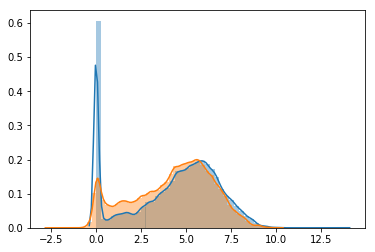

In [33]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof1 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof1 * len(y_train)

del X_train, y_train
gc.collect()

### 2: steam

target_meter 2 (2708713, 15)
cat_features [12, 13, 14]
train 1805808 valid 902905
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.60006	valid_1's l2: 3.25651
[40]	training's l2: 1.86071	valid_1's l2: 2.74772
[60]	training's l2: 1.68049	valid_1's l2: 2.68188
[80]	training's l2: 1.60122	valid_1's l2: 2.6714
Early stopping, best iteration is:
[72]	training's l2: 1.6303	valid_1's l2: 2.66925
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.6303006491536867)]), 'valid_1': OrderedDict([('l2', 2.669250970642563)])})
train 1805809 valid 902904
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.55499	valid_1's l2: 3.65363
[40]	training's l2: 1.8966	valid_1's l2: 2.71842
[60]	training's l2: 1.71229	valid_1's l2: 2.42638
[80]	training's l2: 1.63045	valid_1's l2: 2.31275
[100]	training's l2: 1.57788	valid_1's l2: 2.26698
[120]	training's l2: 1.53516	valid_1's l2: 2.2472
[140]	training's l2: 1.50271	valid_1's l2: 2.24671
Early stopping, best iteration is:


15

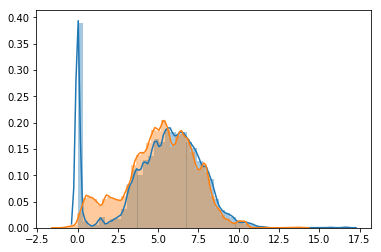

In [34]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof2 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof2 * len(y_train)

del X_train, y_train
gc.collect()

### 3: hotwater

target_meter 3 (1264037, 15)
cat_features [12, 13, 14]
train 842691 valid 421346
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.53343	valid_1's l2: 4.36191
[40]	training's l2: 2.47491	valid_1's l2: 3.36793
[60]	training's l2: 2.09558	valid_1's l2: 3.0205
[80]	training's l2: 1.93817	valid_1's l2: 2.88849
[100]	training's l2: 1.85995	valid_1's l2: 2.83018
[120]	training's l2: 1.81193	valid_1's l2: 2.79475
[140]	training's l2: 1.77387	valid_1's l2: 2.77151
[160]	training's l2: 1.73817	valid_1's l2: 2.76044
[180]	training's l2: 1.71317	valid_1's l2: 2.74796
[200]	training's l2: 1.69206	valid_1's l2: 2.73531
[220]	training's l2: 1.67231	valid_1's l2: 2.73004
[240]	training's l2: 1.65669	valid_1's l2: 2.72469
[260]	training's l2: 1.644	valid_1's l2: 2.72123
[280]	training's l2: 1.63159	valid_1's l2: 2.71916
Early stopping, best iteration is:
[277]	training's l2: 1.63377	valid_1's l2: 2.71831
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.6337686620989413)]), 'valid_1': OrderedDict([('l2', 2

15

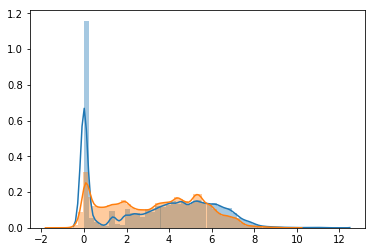

In [35]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof3 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof3 * len(y_train)

del X_train, y_train
gc.collect()

In [36]:
oof_total = oof_total / len(train_df)

# Prediction on test data

In [37]:
del train_df, weather_train_df, building_meta_df 
gc.collect()

7767

In [38]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

set_localtime(weather_test_df)

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_median'] = test_df['building_id'].map(building_median)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())


print('reduce mem usage...')
test_df = reduce_mem_usage(test_df, use_float16=True)
weather_test_df = reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 2266.66 MB
Memory usage after optimization is: 914.64 MB
Decreased by 59.6%
Memory usage of dataframe is 9.78 MB
Memory usage after optimization is: 6.08 MB
Decreased by 37.8%


0

In [39]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission = reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


In [40]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [41]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


iterations 25
predicting 0-th model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




predicting 1-th model



predicting 2-th model



CPU times: user 11min 32s, sys: 6.68 s, total: 11min 39s
Wall time: 3min 28s


19

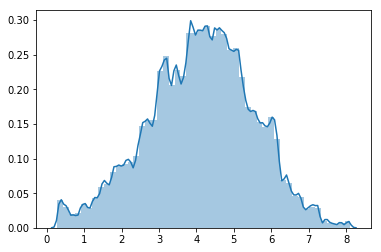

In [42]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




predicting 1-th model



predicting 2-th model



CPU times: user 10min 31s, sys: 2.68 s, total: 10min 34s
Wall time: 2min 55s


16

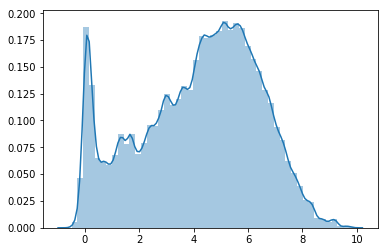

In [43]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




predicting 1-th model



predicting 2-th model



CPU times: user 2min 57s, sys: 1.47 s, total: 2min 58s
Wall time: 53.4 s


16

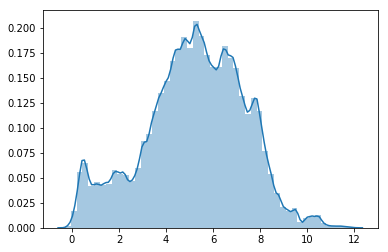

In [44]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




predicting 1-th model



predicting 2-th model


13

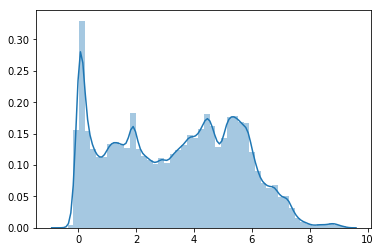

In [45]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [46]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [47]:
if not debug:
    sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')